In [1]:
import pandas as pd
data_rapido = pd.read_csv('data.csv')

In [2]:
data_rapido.head()

,customerid,orderId,yyyymmdd,pickuplocation_lat,pickuplocation_lng,droplocation_lat,droplocation_lng,subtotal,surge
0,182cefbc1000000,RD500000001,20201130,26.116480,91.721947,26.175390,91.773071,114.0,18.82
1,d4cd2fa51000001,RD500000002,20201130,26.164465,91.737915,26.157167,91.691243,0.0,NaN
2,ff315fa91000002,RD500000003,20201130,26.159993,91.682744,26.157949,91.771622,115.0,18.97
3,d4cd2fa51000001,RD500000004,20201130,26.164414,91.736647,26.157167,91.691243,57.0,9.41
4,182cefbc1000000,RD500000005,20201130,26.116480,91.721949,26.175391,91.773072,114.0,18.82


## Renaming Columns

In [3]:
data_rapido.rename(columns = {'yyyymmdd':'Dates','pickuplocation_lat':'pickup_lat','pickuplocation_lng':'pickup_lng',
                       'droplocation_lat':'drop_lat','droplocation_lng':'drop_lng'}, inplace = True)

In [4]:
data_rapido.dtypes

customerid     object
orderId        object
Dates           int64
pickup_lat    float64
pickup_lng    float64
drop_lat      float64
drop_lng      float64
subtotal      float64
surge         float64
dtype: object

## Converting Dates to datetime format

In [5]:
data_rapido['Dates'] = pd.to_datetime(data_rapido['Dates'], format='%Y%m%d')

In [6]:
data_rapido.dtypes

customerid            object
orderId               object
Dates         datetime64[ns]
pickup_lat           float64
pickup_lng           float64
drop_lat             float64
drop_lng             float64
subtotal             float64
surge                float64
dtype: object

### Creating day of the week column 

In [7]:
data_rapido['dayOfWeek'] = data_rapido['Dates'].dt.day_name()

In [8]:
data_rapido = data_rapido[['customerid', 'orderId', 'Dates', 'dayOfWeek', 'pickup_lat', 'pickup_lng','drop_lat', 'drop_lng', 'subtotal', 'surge']]
data_rapido.dtypes

customerid            object
orderId               object
Dates         datetime64[ns]
dayOfWeek             object
pickup_lat           float64
pickup_lng           float64
drop_lat             float64
drop_lng             float64
subtotal             float64
surge                float64
dtype: object

### Data Cleaning and removal of NaN values from the dataset

In [9]:
data_rapido.dropna(how='any', inplace=True)

In [10]:
data_rapido.to_csv("Data_without_outliers.csv")

In [11]:
data2= data_rapido.copy()
data2.shape

(504318, 10)

## for surged customer we can use the below dataset where surge is not equal to 0

#### comment out the below codes to run it with surge = 0

In [12]:
data_rapido_surge = data_rapido[data_rapido['surge'] > 0]
data_rapido_surge.head()

,customerid,orderId,Dates,dayOfWeek,pickup_lat,pickup_lng,drop_lat,drop_lng,subtotal,surge
0,182cefbc1000000,RD500000001,2020-11-30,Monday,26.116480,91.721947,26.175390,91.773071,114.0,18.82
2,ff315fa91000002,RD500000003,2020-11-30,Monday,26.159993,91.682744,26.157949,91.771622,115.0,18.97
3,d4cd2fa51000001,RD500000004,2020-11-30,Monday,26.164414,91.736647,26.157167,91.691243,57.0,9.41
4,182cefbc1000000,RD500000005,2020-11-30,Monday,26.116480,91.721949,26.175391,91.773072,114.0,18.82
5,51d2be661000003,RD500000006,2020-11-30,Monday,26.119558,91.825289,26.157698,91.789095,61.0,10.05


In [13]:
data2 = data_rapido_surge.copy()

In [14]:
data2.shape

(112573, 10)

In [15]:
#Importing Libraries
!pip3 install graphviz
!pip3 install toolz
!pip install gpxpy
!pip install folium
!pip install keras

import pandas as pd#pandas to create small dataframes 
import folium #open street map
import numpy as np

# matplotlib: used to plot graphs
import matplotlib
%matplotlib inline
# matplotlib.use('nbagg') : matplotlib uses this protocall which makes plots more user intractive like zoom in and zoom out
matplotlib.use('nbagg')
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  

# this lib is used while we calculate the stight line distance between two (lat,lon) pairs in miles
import gpxpy.geo #Get the haversine distance

from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pdb
import warnings

warnings.filterwarnings("ignore")

In [16]:
# we will collect all the points outside the bounding box of guwahati city 
outlier_locations = data2[((data2.pickup_lng <= 91.801794) | (data2.pickup_lat <= 26.208901)| \
                   (data2.pickup_lng >= 91.702402) | (data2.pickup_lat >= 26.147896))]

# 91.702402,26.147896,91.801794,26.208901

# creating a map with the a base location
# read more about the folium here: http://folium.readthedocs.io/en/latest/quickstart.html

map_osm = folium.Map(location=[26.148043, 91.731377], tiles='Stamen Toner')

sample_locations = outlier_locations.head(1000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_lat']) != 0:
        folium.Marker(list((j['pickup_lat'],j['pickup_lng']))).add_to(map_osm)
map_osm

## Constraints on which we design our model to Choose the optimal K

(1) inter cluster distance should be less than 2 miles (this ensures that region cant be too large)

(2) Minimum Inter cluster Distance should be greater than 0.5 miles (this ensures that region cant be too small)

No two clusters are more than 2 miles and less than 0.5 miles away

In [17]:
#trying different cluster sizes to choose the right K in K-means
coords = data2[['pickup_lat', 'pickup_lng']].values
neighbours=[]

def find_min_distance(cluster_centers, cluster_len):
    nice_points = 0
    wrong_points = 0
    less2 = []
    more2 = []
    min_dist=1000
    for i in range(0, cluster_len):
        nice_points = 0
        wrong_points = 0
        for j in range(0, cluster_len):
            if j!=i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],cluster_centers[j][0], cluster_centers[j][1])
                min_dist = min(min_dist,distance/(1.60934*1000))
                if (distance/(1.60934*1000)) <= 2:
                    nice_points +=1
                else:
                    wrong_points += 1
        less2.append(nice_points)
        more2.append(wrong_points)
    neighbours.append(less2)
    print ("On choosing a cluster size of ",cluster_len,"\nAvg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2):",
           np.ceil(sum(less2)/len(less2)), "\nAvg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2):", np.ceil(sum(more2)/len(more2)),
           "\nMin inter-cluster distance = ",min_dist,"\n---")

def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000,random_state=42).fit(coords)
    data2['pickup_cluster'] = kmeans.predict(data2[['pickup_lat', 'pickup_lng']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len

# we need to choose number of clusters so that, there are more number of cluster regions 
#that are close to any cluster center
# and make sure that the minimum inter cluster should not be very less
for increment in range(10, 100, 10):
    cluster_centers, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centers, cluster_len)

On choosing a cluster size of  10 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 2.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 8.0 
Min inter-cluster distance =  1.143976691137347 
---
On choosing a cluster size of  20 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 5.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 15.0 
Min inter-cluster distance =  0.8490068395541046 
---
On choosing a cluster size of  30 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 7.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 23.0 
Min inter-cluster distance =  0.735786667389048 
---
On choosing a cluster size of  40 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 9.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 31.0 
Min inter-cluster distance = 

#### we choose 60 cause we want th clusters to be well separated for this big dataset and the inter cluster distance should be less than 2 miles as 2 miles can be easily travelled in 10 minutes.

#### 2 mies we can cover it in 10 minutes and 0.5 miles we can cover it in approx 3 minutes

In [18]:
#if check for the 60 clusters you can observe that there are two clusters with only 0.3 miles apart from each other
# so we choose 60 clusters for solve the further problem

#if check for the 40 clusters you can observe that there are two clusters with only 0.3 miles apart from each other
# so we choose 40 clusters for solve the further problem for sruge not equal to 0

# Getting 40 clusters using the kmeans for sruge not equal to 0
# Getting 60 clusters using the kmeans 
kmeans = MiniBatchKMeans(n_clusters=40, batch_size=10000,random_state=0).fit(coords)
data2['pickup_cluster'] = kmeans.predict(data2[['pickup_lat', 'pickup_lng']])

In [19]:
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)
map_osm = folium.Map(location=[26.148043, 91.731377], tiles='Stamen Toner')
for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])), popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))).add_to(map_osm)
map_osm

In [20]:
data2.head(5)

,customerid,orderId,Dates,dayOfWeek,pickup_lat,pickup_lng,drop_lat,drop_lng,subtotal,surge,pickup_cluster
0,182cefbc1000000,RD500000001,2020-11-30,Monday,26.116480,91.721947,26.175390,91.773071,114.0,18.82,31
2,ff315fa91000002,RD500000003,2020-11-30,Monday,26.159993,91.682744,26.157949,91.771622,115.0,18.97,5
3,d4cd2fa51000001,RD500000004,2020-11-30,Monday,26.164414,91.736647,26.157167,91.691243,57.0,9.41,3
4,182cefbc1000000,RD500000005,2020-11-30,Monday,26.116480,91.721949,26.175391,91.773072,114.0,18.82,31
5,51d2be661000003,RD500000006,2020-11-30,Monday,26.119558,91.825289,26.157698,91.789095,61.0,10.05,6


<IPython.core.display.Javascript object>


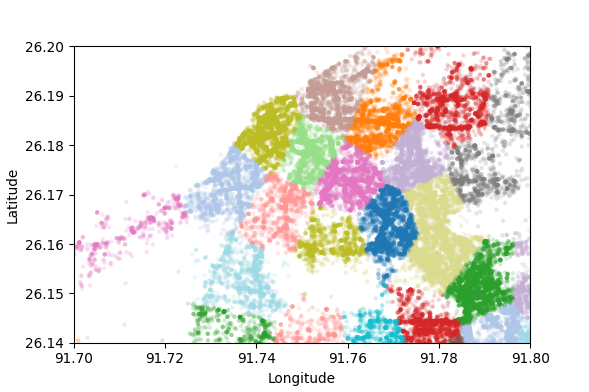

In [21]:
def plot_clusters(frame):
    city_long_border = (91.70, 91.80)
    city_lat_border = (26.14,26.20)
    fig, ax = plt.subplots(ncols=1,nrows=1)
    ax.scatter(frame.pickup_lng.values[:100000], frame.pickup_lat.values[:100000],
               s=10,lw=0, c= frame.pickup_cluster.values[:100000],cmap='tab20',alpha=0.2)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()
    
    
plot_clusters(data2)

In [22]:
data2.to_csv("Data_with_40_clusters.csv")

In [23]:
data2.head()

,customerid,orderId,Dates,dayOfWeek,pickup_lat,pickup_lng,drop_lat,drop_lng,subtotal,surge,pickup_cluster
0,182cefbc1000000,RD500000001,2020-11-30,Monday,26.116480,91.721947,26.175390,91.773071,114.0,18.82,31
2,ff315fa91000002,RD500000003,2020-11-30,Monday,26.159993,91.682744,26.157949,91.771622,115.0,18.97,5
3,d4cd2fa51000001,RD500000004,2020-11-30,Monday,26.164414,91.736647,26.157167,91.691243,57.0,9.41,3
4,182cefbc1000000,RD500000005,2020-11-30,Monday,26.116480,91.721949,26.175391,91.773072,114.0,18.82,31
5,51d2be661000003,RD500000006,2020-11-30,Monday,26.119558,91.825289,26.157698,91.789095,61.0,10.05,6


In [24]:
data3 = data2[['Dates', 'dayOfWeek','customerid', 'orderId', 'subtotal', 'surge', 'pickup_cluster']]
data3

,Dates,dayOfWeek,customerid,orderId,subtotal,surge,pickup_cluster
0,2020-11-30,Monday,182cefbc1000000,RD500000001,114.0,18.82,31
2,2020-11-30,Monday,ff315fa91000002,RD500000003,115.0,18.97,5
3,2020-11-30,Monday,d4cd2fa51000001,RD500000004,57.0,9.41,3
4,2020-11-30,Monday,182cefbc1000000,RD500000005,114.0,18.82,31
5,2020-11-30,Monday,51d2be661000003,RD500000006,61.0,10.05,6
...,...,...,...,...,...,...,...
537939,2020-11-01,Sunday,b150f5b71077366,RD500537940,66.0,8.53,18
537947,2020-11-01,Sunday,ff5138821091243,RD500537948,46.0,5.90,21
537959,2020-11-01,Sunday,eaea32d21091025,RD500537960,110.0,14.22,4
537960,2020-11-01,Sunday,1.25864E+14,RD500537961,51.0,6.55,4


In [25]:
#Number of unique customers = 89151
data3.loc[data3.groupby('customerid').Dates.idxmax()]
#customerid_unique = data3.loc[data3.groupby('customerid').Dates.idxmax()]
#customerid_unique

,Dates,dayOfWeek,customerid,orderId,subtotal,surge,pickup_cluster
450583,2020-11-06,Friday,00013c1b1014073,RD500450584,50.0,4.41,1
349496,2020-11-11,Wednesday,0005295e1071810,RD500349497,47.0,5.98,17
368396,2020-11-10,Tuesday,000ffa991050038,RD500368397,123.0,15.85,1
246002,2020-11-17,Tuesday,00107bae1058215,RD500246003,70.0,8.96,0
378966,2020-11-10,Tuesday,0012327c1039560,RD500378967,31.0,2.69,3
...,...,...,...,...,...,...,...
41054,2020-11-28,Saturday,fff63e0e1017528,RD500041055,35.0,5.22,1
260163,2020-11-13,Friday,fff9c5c91060903,RD500260164,32.0,4.00,18
255144,2020-11-15,Sunday,fffa4f1a1059892,RD500255145,60.0,7.66,24
223215,2020-11-18,Wednesday,fffaccc31055044,RD500223216,27.0,7.22,1


In [26]:
# which customer belong to which pickup_cluster
customerid_pupcluster = data3.groupby("pickup_cluster")["customerid"].count()
customerid_pupcluster.sort_values(ascending=False)

pickup_cluster
9     7852
35    6316
0     5924
18    5053
32    4909
38    4740
24    4648
21    4504
2     4457
17    4331
10    3908
37    3597
22    3545
4     3314
34    3268
1     3192
30    3130
3     3000
13    2921
12    2840
11    2795
19    2665
39    2071
36    2026
14    1662
6     1567
15    1543
33    1538
29    1527
27    1476
5     1357
28    1356
8     1098
7      910
16     874
25     732
31     658
26     634
23     572
20      63
Name: customerid, dtype: int64

In [27]:
print(data3.groupby(["Dates","dayOfWeek", "pickup_cluster"])["customerid"].count())

Dates       dayOfWeek  pickup_cluster
2020-11-01  Sunday     0                  85
                       1                  39
                       2                  46
                       3                  48
                       4                  53
                                        ... 
2020-11-30  Monday     35                320
                       36                115
                       37                178
                       38                240
                       39                 56
Name: customerid, Length: 1186, dtype: int64


In [28]:
import datetime
data3.head()

,Dates,dayOfWeek,customerid,orderId,subtotal,surge,pickup_cluster
0,2020-11-30,Monday,182cefbc1000000,RD500000001,114.0,18.82,31
2,2020-11-30,Monday,ff315fa91000002,RD500000003,115.0,18.97,5
3,2020-11-30,Monday,d4cd2fa51000001,RD500000004,57.0,9.41,3
4,2020-11-30,Monday,182cefbc1000000,RD500000005,114.0,18.82,31
5,2020-11-30,Monday,51d2be661000003,RD500000006,61.0,10.05,6


In [29]:
import numpy as np
data3.dayOfWeek.value_counts().sort_index()
#data_rapido1.Dates.value_counts().sort_index()

Friday       24908
Monday       28561
Saturday     11151
Sunday        7262
Thursday     11354
Tuesday      15132
Wednesday    14205
Name: dayOfWeek, dtype: int64

<IPython.core.display.Javascript object>


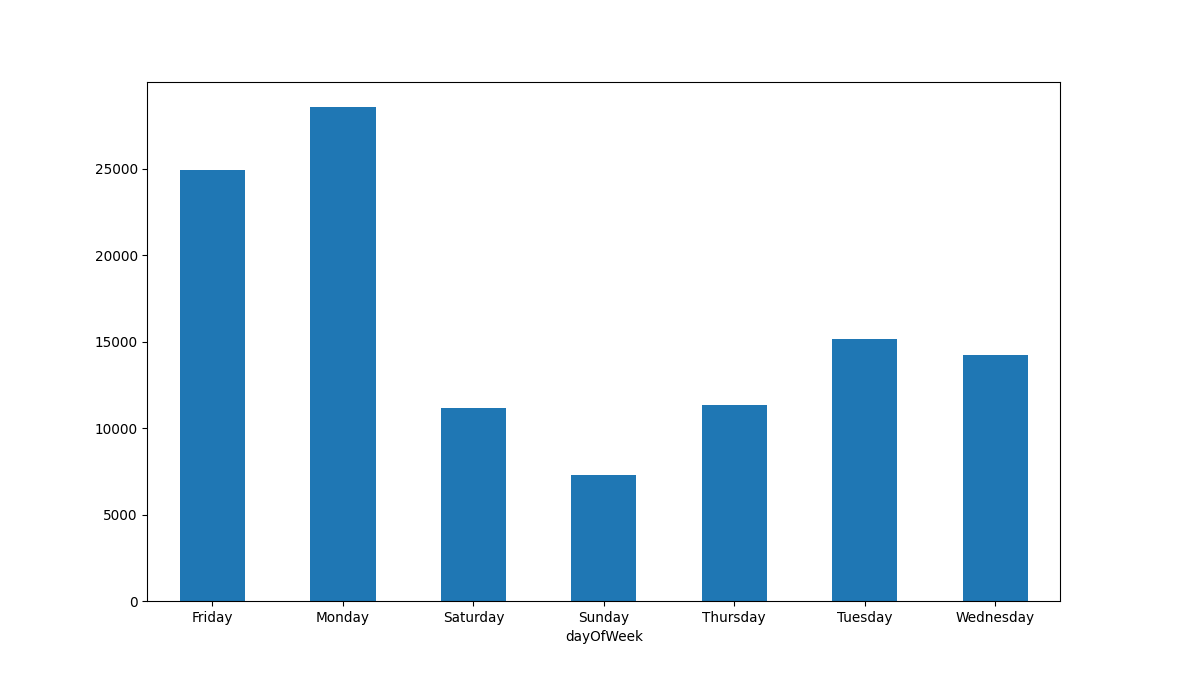

<AxesSubplot:xlabel='dayOfWeek'>

In [30]:
fig, axs = plt.subplots(figsize=(12, 7))
data3.groupby(data3["dayOfWeek"])["surge"].count().plot(kind='bar', rot=0, ax=axs)

In [31]:
data3.rename(columns = {'customerid':'userId', 'orderId':'id','Dates':'created','subtotal':'total'}, inplace = True)
data3.head()

,created,dayOfWeek,userId,id,total,surge,pickup_cluster
0,2020-11-30,Monday,182cefbc1000000,RD500000001,114.0,18.82,31
2,2020-11-30,Monday,ff315fa91000002,RD500000003,115.0,18.97,5
3,2020-11-30,Monday,d4cd2fa51000001,RD500000004,57.0,9.41,3
4,2020-11-30,Monday,182cefbc1000000,RD500000005,114.0,18.82,31
5,2020-11-30,Monday,51d2be661000003,RD500000006,61.0,10.05,6


We have total 504318 data points with 6 variables

Our Data Have 4 columns: id: id is the order id

userId: userId is the Id of the user who placed the order

total: the amount of order the user placed

created: Date and time of order placed


# Creating a function which will take the created data and return a group value

Group Value - Date if the Date is monday else Date of upcoming monday

In [32]:
def next_weekday(d):
    '''
    Convert Order Date to a Order Group, Represented by Year-Month-Date Format where
    Date is the same date if the input date is monday 
    else the date is next monday date of provided date.
    '''
    day_of_week = d.weekday()
    if day_of_week !=0:
        d = d + datetime.timedelta(7 - day_of_week)
        
    return d.strftime('%Y-%m-%d')

## Creating Cohort Group
Grouping customers who placed there first order in same week

In [33]:
data3.set_index('userId', inplace=True)

In [34]:
data3['CohortGroup'] = data3.groupby(level =0)['created'].min().apply(next_weekday)

In [35]:
data3.head()

,created,dayOfWeek,id,total,surge,pickup_cluster,CohortGroup
userId,,,,,,,
182cefbc1000000,2020-11-30,Monday,RD500000001,114.0,18.82,31,2020-11-30
ff315fa91000002,2020-11-30,Monday,RD500000003,115.0,18.97,5,2020-11-30
d4cd2fa51000001,2020-11-30,Monday,RD500000004,57.0,9.41,3,2020-11-09
182cefbc1000000,2020-11-30,Monday,RD500000005,114.0,18.82,31,2020-11-30
51d2be661000003,2020-11-30,Monday,RD500000006,61.0,10.05,6,2020-11-30


In [36]:
data3.reset_index(inplace=True)

In [37]:
data3.head()

,userId,created,dayOfWeek,id,total,surge,pickup_cluster,CohortGroup
0,182cefbc1000000,2020-11-30,Monday,RD500000001,114.0,18.82,31,2020-11-30
1,ff315fa91000002,2020-11-30,Monday,RD500000003,115.0,18.97,5,2020-11-30
2,d4cd2fa51000001,2020-11-30,Monday,RD500000004,57.0,9.41,3,2020-11-09
3,182cefbc1000000,2020-11-30,Monday,RD500000005,114.0,18.82,31,2020-11-30
4,51d2be661000003,2020-11-30,Monday,RD500000006,61.0,10.05,6,2020-11-30


## Adding another column name OrderPeriod which holds the group name when the order placed

In [38]:
data3['OrderPeriod'] = data3.created.apply(next_weekday)

### We made two columns from 'created' column. CohortGroup holds the week date when the customer placed the order and OrderPeriod holds the week date whenever the customer placed the order

In [39]:
data3.head()

,userId,created,dayOfWeek,id,total,surge,pickup_cluster,CohortGroup,OrderPeriod
0,182cefbc1000000,2020-11-30,Monday,RD500000001,114.0,18.82,31,2020-11-30,2020-11-30
1,ff315fa91000002,2020-11-30,Monday,RD500000003,115.0,18.97,5,2020-11-30,2020-11-30
2,d4cd2fa51000001,2020-11-30,Monday,RD500000004,57.0,9.41,3,2020-11-09,2020-11-30
3,182cefbc1000000,2020-11-30,Monday,RD500000005,114.0,18.82,31,2020-11-30,2020-11-30
4,51d2be661000003,2020-11-30,Monday,RD500000006,61.0,10.05,6,2020-11-30,2020-11-30


### Grouping data by CohortGroup then by OrderPeriod and count unique counts

In [40]:
grouped = data3.groupby(['CohortGroup', 'OrderPeriod', 'pickup_cluster']).agg({'userId': pd.Series.nunique})

In [41]:
grouped

userId
CohortGroup OrderPeriod pickup_cluster        
2020-11-02  2020-11-02  0                  193
                        1                  106
                        2                  154
                        3                   82
                        4                   92
...                                        ...
2020-11-30  2020-11-30  35                 421
                        36                 133
                        37                 257
                        38                 336
                        39                 113

[595 rows x 1 columns]

In [42]:
def cohort_period(df):
    '''
    Takes a dataframe 
    sort dataframe by sub -group 
    creates a new column with index (for future purpose)
    '''
    df['CohortPeriod'] = np.arange(len(df))
    return df

In [43]:
retention = grouped.groupby(level=0).apply(cohort_period)

In [44]:
retention

userId  CohortPeriod
CohortGroup OrderPeriod pickup_cluster                      
2020-11-02  2020-11-02  0                  193             0
                        1                  106             1
                        2                  154             2
                        3                   82             3
                        4                   92             4
...                                        ...           ...
2020-11-30  2020-11-30  35                 421            35
                        36                 133            36
                        37                 257            37
                        38                 336            38
                        39                 113            39

[595 rows x 2 columns]

In [45]:
retention.reset_index(inplace=True)

In [46]:
retention.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

## Unstaking data to get a data frame where columns: CohortPeriod and index: CohortGroup

In [47]:
unstacked = retention['userId'].unstack(1)

In [48]:
unstacked.head(10)

CohortPeriod,0,1,2,3,4,5,6,7,8,9,...,187,188,189,190,191,192,193,194,195,196
CohortGroup,,,,,,,,,,,,,,,,,,,,,
2020-11-02,193.0,106.0,154.0,82.0,92.0,83.0,65.0,27.0,47.0,256.0,...,32.0,4.0,30.0,14.0,33.0,67.0,20.0,47.0,45.0,23.0
2020-11-09,805.0,347.0,531.0,450.0,447.0,163.0,193.0,116.0,123.0,965.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-16,765.0,266.0,396.0,398.0,411.0,103.0,143.0,97.0,129.0,906.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-23,420.0,209.0,296.0,284.0,270.0,196.0,227.0,64.0,76.0,481.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-30,437.0,220.0,322.0,220.0,222.0,109.0,170.0,73.0,79.0,531.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### We want to observe customer retention for next 4 weeks for each cohort group where the first week of order is Week 0

In [49]:
retention_6 = unstacked[[i for i in range(7)]]

In [50]:
retention_6.columns = [f'Week {i}' for i in retention_6.columns]

In [51]:
retention_6

,Week 0,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6
CohortGroup,,,,,,,
2020-11-02,193.0,106.0,154.0,82.0,92.0,83.0,65.0
2020-11-09,805.0,347.0,531.0,450.0,447.0,163.0,193.0
2020-11-16,765.0,266.0,396.0,398.0,411.0,103.0,143.0
2020-11-23,420.0,209.0,296.0,284.0,270.0,196.0,227.0
2020-11-30,437.0,220.0,322.0,220.0,222.0,109.0,170.0


## Now for better visualization and understanding we will convert our data to percentage

Dividing Column Week 1-6 by Week 0 (and keeping columns Week 1- 6) as Week 0 always will be 100%

In [52]:
retention_6_per = retention_6.iloc[:,1:].div(retention_6['Week 0'] , axis=0)

In [53]:
retention_6_per

,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6
CohortGroup,,,,,,
2020-11-02,0.549223,0.797927,0.424870,0.476684,0.430052,0.336788
2020-11-09,0.431056,0.659627,0.559006,0.555280,0.202484,0.239752
2020-11-16,0.347712,0.517647,0.520261,0.537255,0.134641,0.186928
2020-11-23,0.497619,0.704762,0.676190,0.642857,0.466667,0.540476
2020-11-30,0.503432,0.736842,0.503432,0.508009,0.249428,0.389016


## Let's make our data more explanatory by visualizing it

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
import seaborn as sns

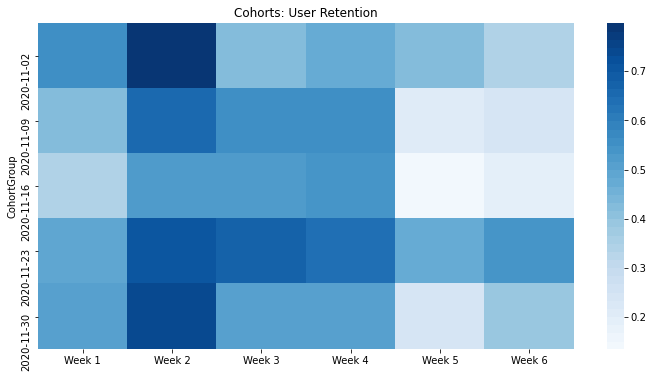

In [56]:
plt.figure(figsize=(12,6))
plt.title('Cohorts: User Retention')
heat_map = sns.heatmap(retention_6_per, cmap=sns.color_palette('Blues', 40))
figure = heat_map.get_figure()    
figure.savefig('user retention.png', dpi=1000)